## Data Reduction of MQ-SCExAO Lab Spectrograph

### 7 cores single mode fiber input, oriented in rotation for maximum seperation in cross dispersion direction

#### Setup Notes

Using a ZWO ASI183MM CMOS camera as the detector


* Sensor type	CMOS
* Sensor specification	 1/3″ CMOS
* Pixel Size: 2.4µm
* Bit rate: 12bit output (12bit ADC)

The setups:

Using the inner 7 cores of a 19 core Single mode Multicore Fiber
laser cut brass aperture inserted between the ferrule and the FC/PC connector are masking the outer fiber

other end of the MCF has 3D nano printed microlenses and is couple to SCExAO

Spectrograph has an R4 grating, whihc is fed from a reimaging fiber input and collimated by a 200 mm ITL lens

cross dispersion is done by a 200 line/mm grating, some significant gamma angle

camera lens is another 200 mm TTL lens

Setup is non enclosed

### import the necessary packages

In [1317]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks
from scipy.signal import medfilt

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches

import ccdproc
from astropy.nddata import CCDData
import astropy.units as u

import os
import glob

### Function definitions

### Set the pixel size for your detector
The ZWO ASI183MM camera 

In [1318]:
pixelsize=2.4

### Set up data store directories

In [1319]:
datastore_path="c:/cloudstor/datastore/SCExAO-MCF/"
proc_dir="processed/"
run_dir="16-10-2019/"
run_dir2="18-10-2019/"

### Collect filenames

In [1320]:
#bias_files=["super-k-0001bias.fit","super-k-0002bias.fit","super-k-0003bias.fit"]

bias_files=glob.glob(os.path.join(datastore_path,run_dir,"super*bias*"))

print(bias_files)

#dark_files=["gamma-dark-480.fit","gamma-dark-480-2.fit"]

dark_files=glob.glob(os.path.join(datastore_path,run_dir,"*dark-480*"))

print(dark_files)


#flat_files=[datastore_path + run_dir + "super-k-flat-10.fit"]
flat_files=[datastore_path + run_dir2 + "halogen.fit"]


print(flat_files)

science_files=[datastore_path + run_dir + "gamma_1.fit"]

print(science_files)

cal_files=glob.glob(os.path.join(datastore_path,run_dir,"*xe-300*"))

print(cal_files)


['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0001bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0002bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0003bias.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480-2.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480.fit']
['c:/cloudstor/datastore/SCExAO-MCF/18-10-2019/halogen.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019/gamma_1.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-1.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-2.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-3.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300.fit']


## I. Prepare Images

### Create Master bias

In [1321]:
mb_filename=os.path.join(datastore_path,proc_dir,"masterbias.fit")

if os.path.exists(mb_filename) == False:
    mb_ccd = ccdproc.combine(bias_files,mb_filename,method="median",unit="adu")
else:
    mb_ccd = CCDData.read(mb_filename)  
    

print(np.mean(mb_ccd))
print(np.min(mb_ccd))
print(np.max(mb_ccd))


712.7581199874419
420.0
1004.0


### Create Master dark and bias correct it

In [1322]:
dk_filename=os.path.join(datastore_path,proc_dir,"masterdark.fit")
dark_exp = 300.0*u.second
flat_exp = 300.0*u.second
sci_exp = 480.0*u.second
cal_exp = 300.0*u.second


if os.path.exists(dk_filename) == False:
    darkcombined = ccdproc.combine(dark_files,method="median",unit="adu")
    dk_ccd = ccdproc.subtract_bias(darkcombined, mb_ccd)
    dk_ccd.write(dk_filename)
else:
    dk_ccd = CCDData.read(dk_filename)

darkpixel = (np.mean(dk_ccd)).round(0)
print(darkpixel)
print(np.min(dk_ccd))
print(np.max(dk_ccd))


38.0
-336.0
16428.0


### Preview the halogen flat, 300s exposure

The first set of complete cores is order 1 (at the bottom of the frame). Order 2 is the next one up the frame and so forth.

The left side of the from is the bottom of the chip, closest to the bench.

Given that the cross disperser is a grating, increasing order seperation occurs as the top of frame is reached, where the wavelengths are longer. 

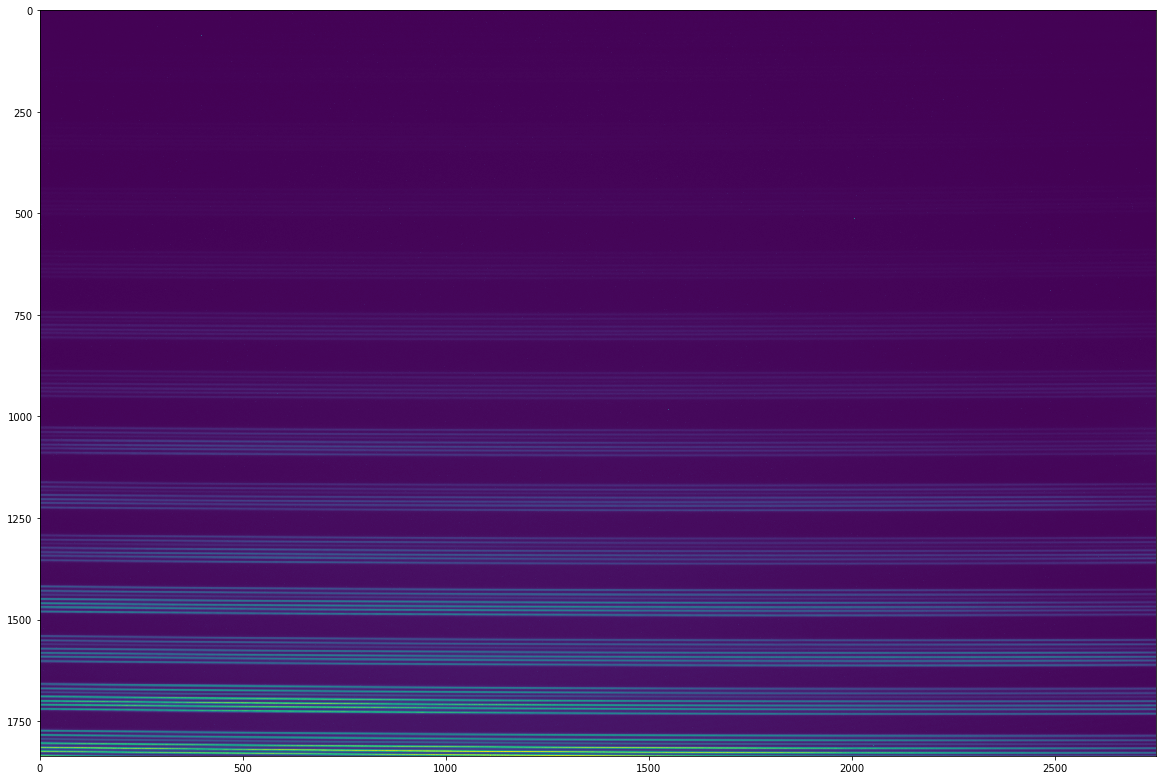

In [1323]:
flat_ccd = CCDData.read(flat_files[0],unit="adu")

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(flat_ccd,origin='upper',cmap='viridis')

### Preview the science exposure

In [1324]:

sci_ccd = CCDData.read(science_files[0], unit="adu")

#Exposure is binned 2, 480 sec of Gamma gem, taken through SCExAO, 3dprinted MCF at highest observability

In [1325]:
sci_ccd.shape

detector_h=1836
detector_w=2748

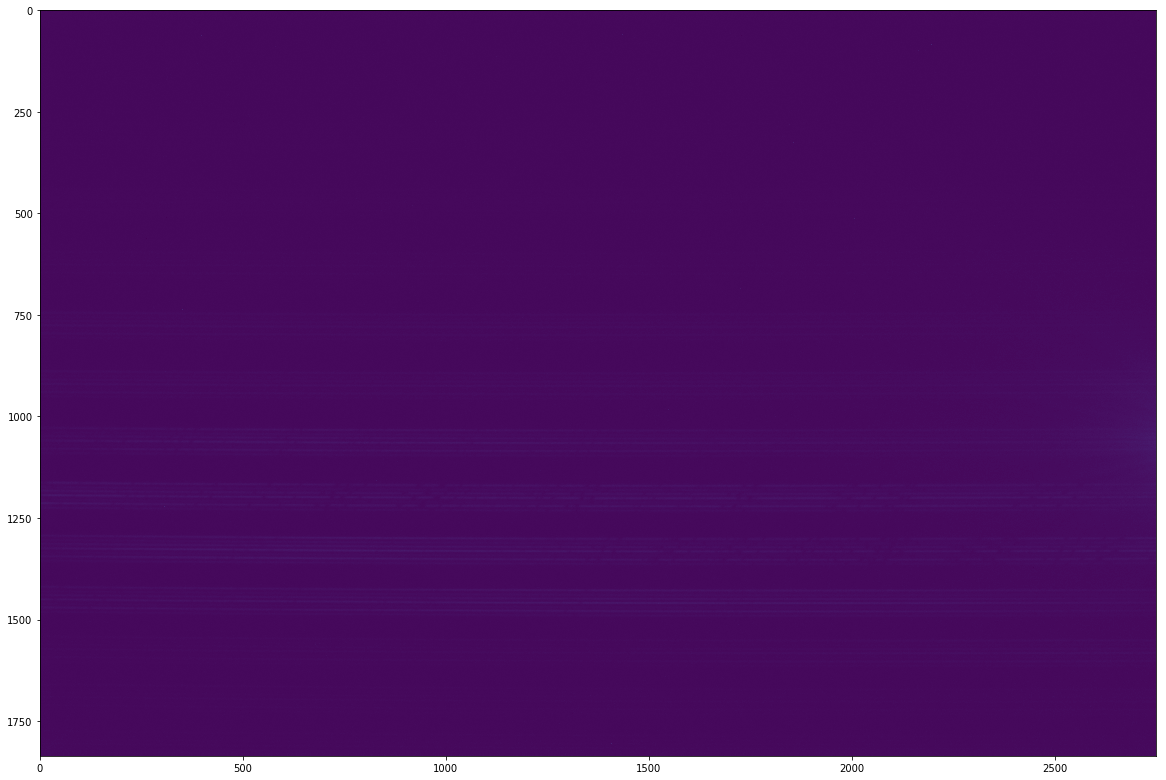

In [1326]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(sci_ccd,origin='upper',cmap='viridis')

### Subtract Darks and Bias from flat exposure

Text(0.5,1,'Orders')

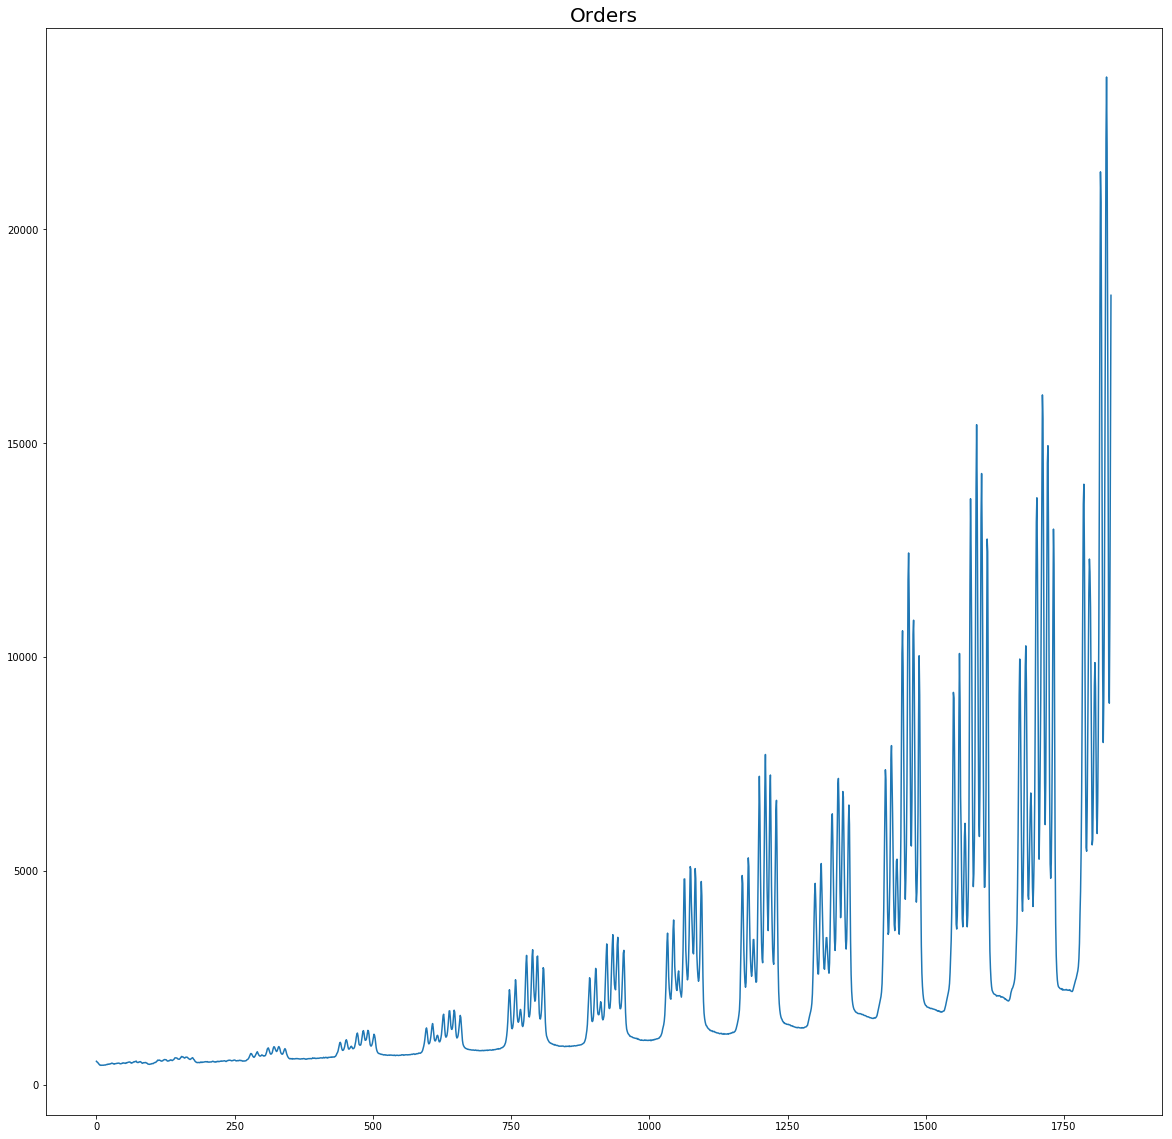

In [1327]:


procflat = ccdproc.subtract_bias(flat_ccd, mb_ccd)
procflat = ccdproc.subtract_dark(procflat,dk_ccd, data_exposure = flat_exp, dark_exposure = dark_exp, scale = True)

#median filter
#procflat = ccdproc.median_filter(procflat,size=2)

#instead of median filter, do a swap of the negative values with the dark pixel median
procflat.data[procflat.data < 0] = darkpixel

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
plt.title("Orders",fontsize=20)

Text(0.5,1,'Blaze trace of whole frame')

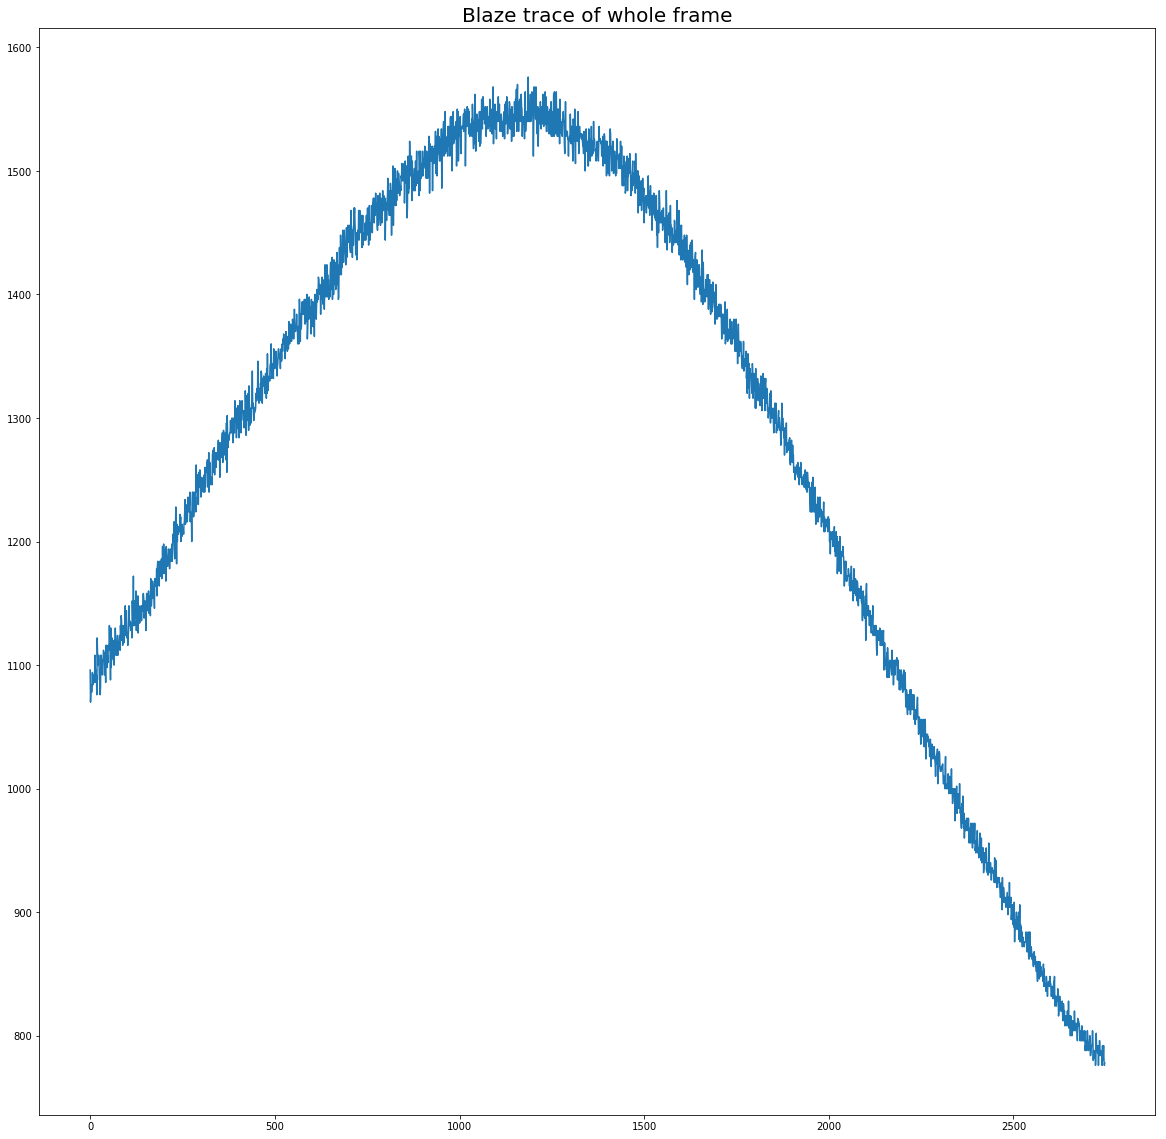

In [1328]:
plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=0))
plt.title("Blaze trace of whole frame",fontsize=20)

### Subtract Darks and Bias from xe exposure

In [1329]:
cal_ccd = CCDData.read(cal_files[0], unit="adu")

proccal = ccdproc.subtract_bias(cal_ccd, mb_ccd)


proccal = ccdproc.subtract_dark(proccal,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)

proccal.data[proccal.data < 0] = darkpixel

#proccal = ccdproc.median_filter(proccal,size=2)


### Subtract Darks and Bias from science exposure

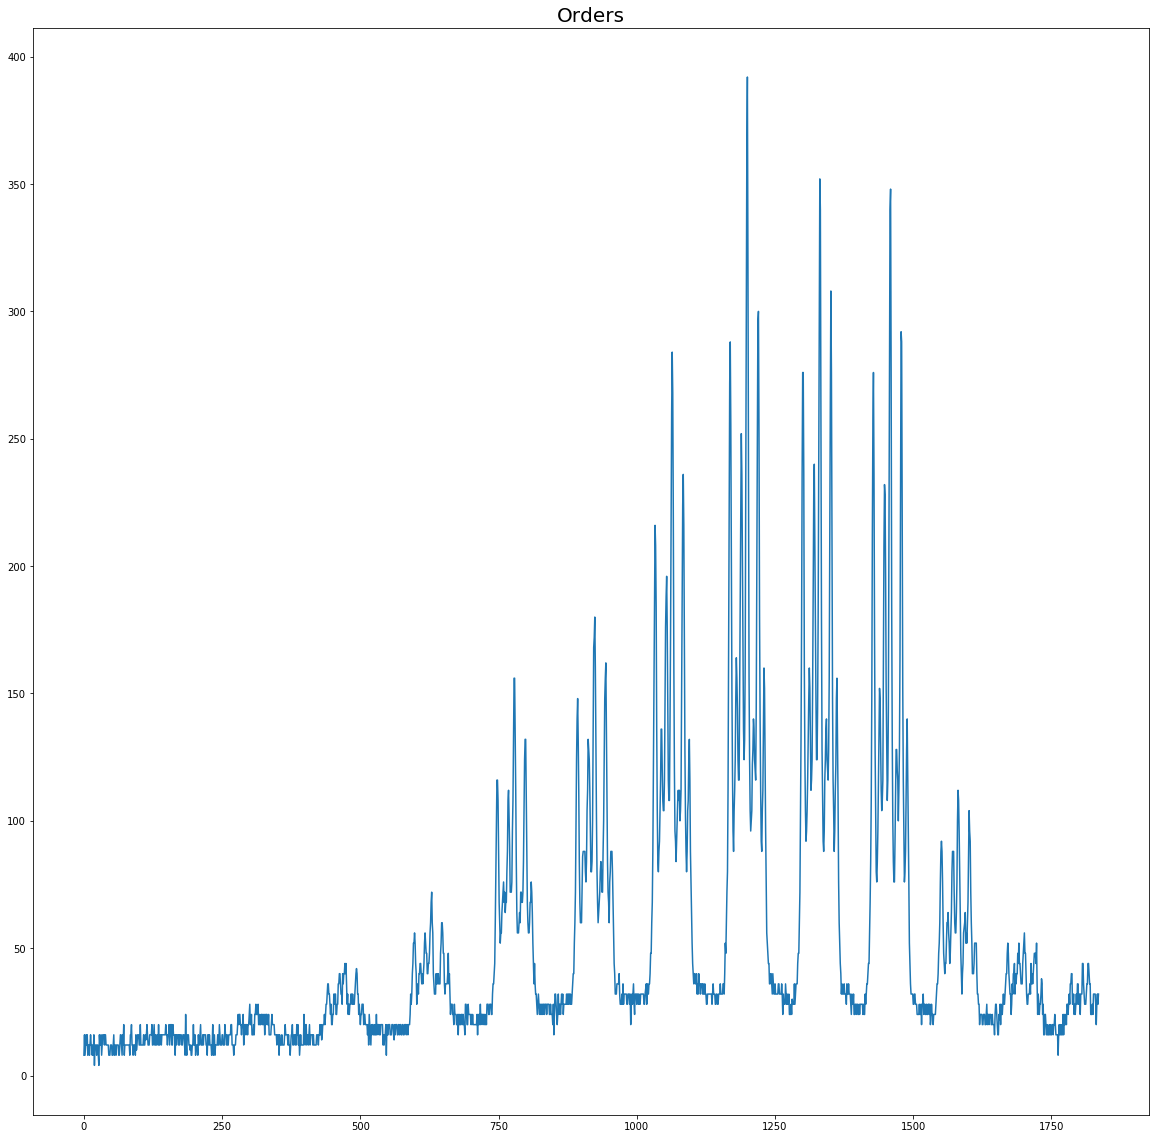

In [1330]:
procsci = ccdproc.subtract_bias(sci_ccd, mb_ccd)


procsci = ccdproc.subtract_dark(procsci,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)


plt.figure(figsize=(20, 20))
plt.plot(np.median(procsci,axis=1))
plt.title("Orders",fontsize=20)

procsci.data[procsci.data < 0] = darkpixel

#procsci = ccdproc.median_filter(procsci,size=2)



### Plot the processed frames

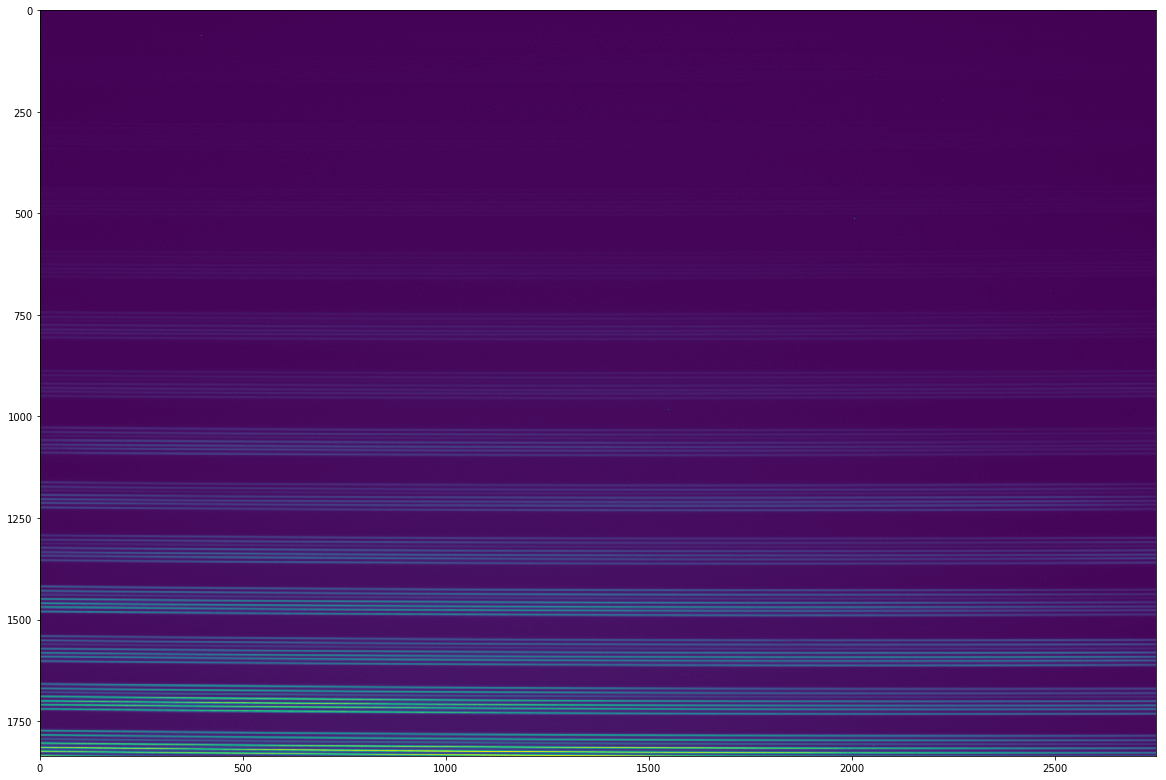

In [1331]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procflat,origin='upper',cmap='viridis')

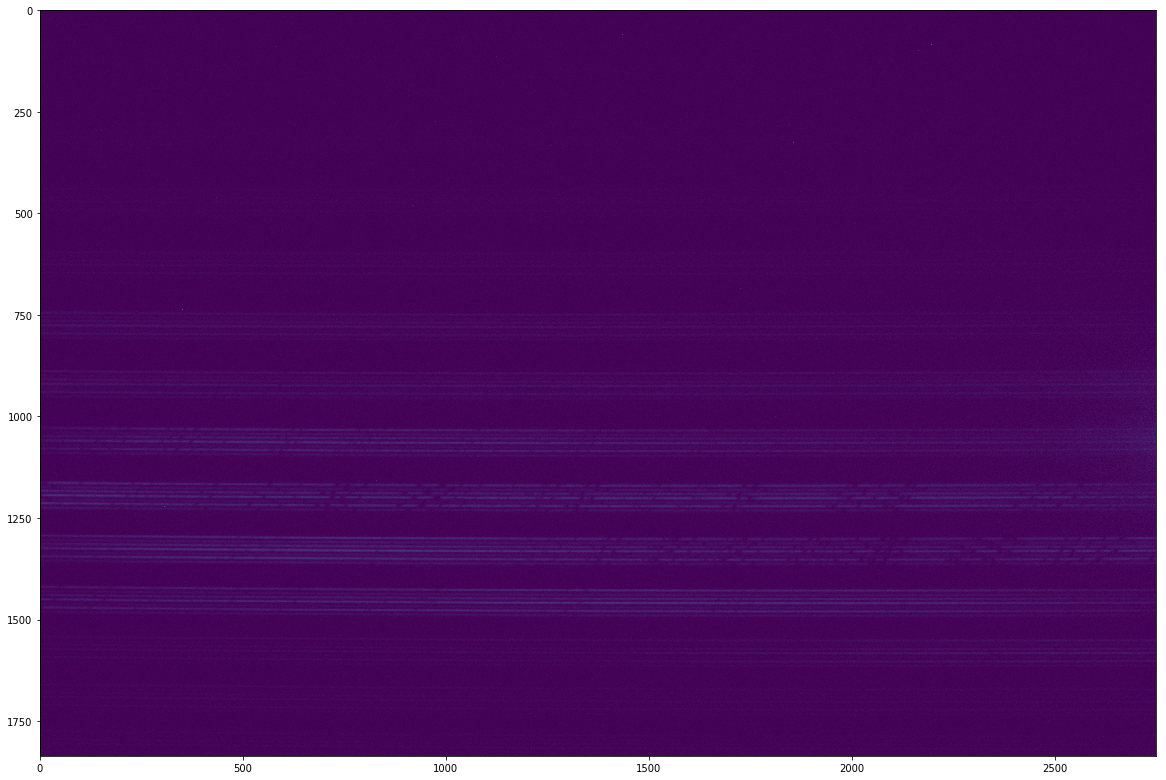

In [1332]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procsci,origin='upper',cmap='viridis')

### II. Use the flat exposure to locate order locations

### Show the selection on the frame and mark the orders manually

count orders from right to left

Text(0.5,1,'Orders')

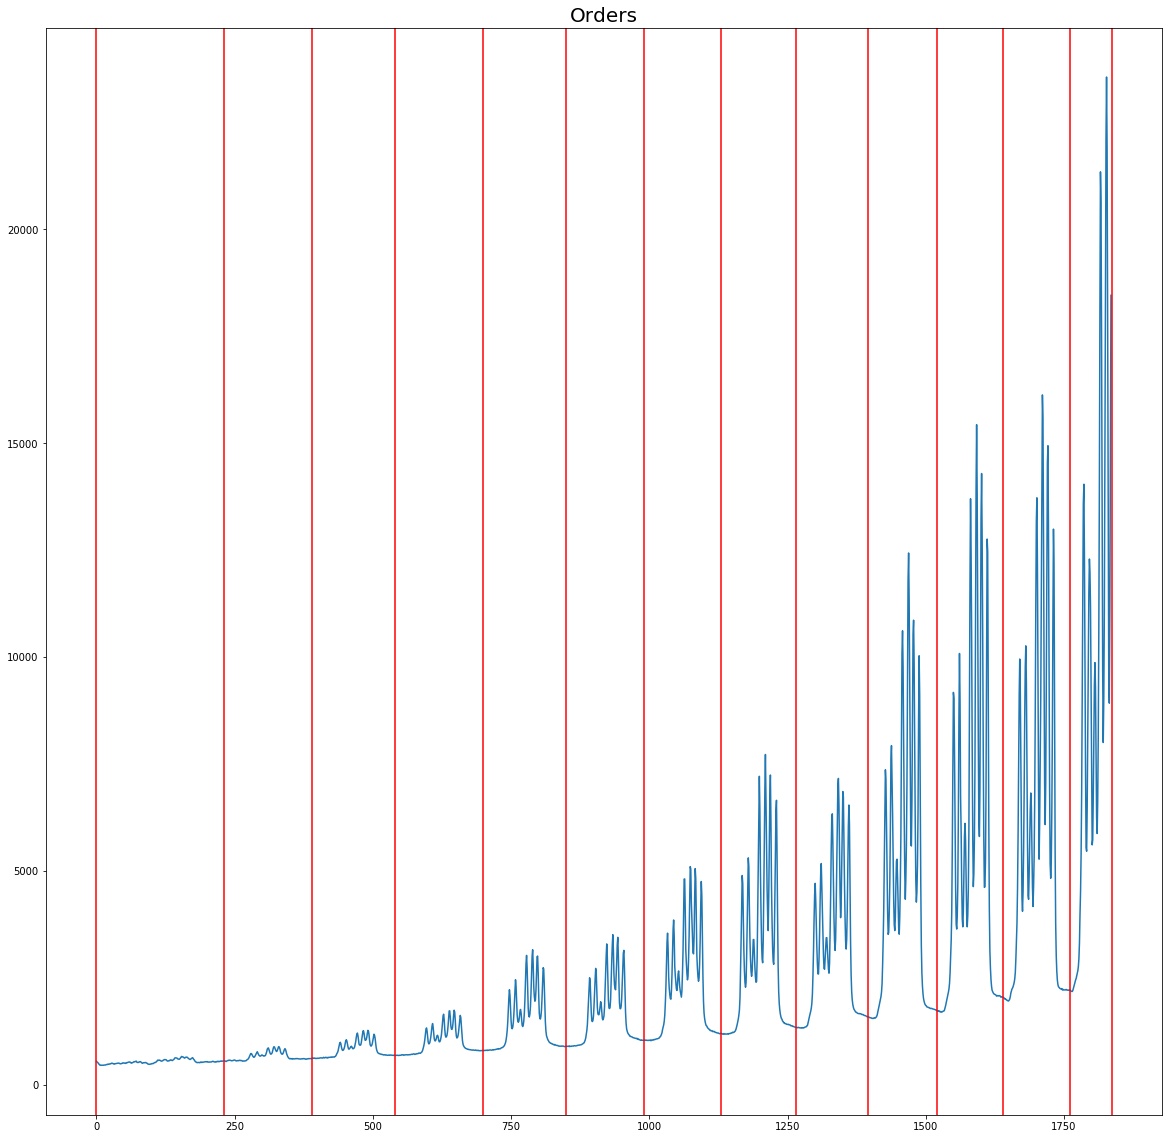

In [1333]:
flat_median = np.median(procflat,axis=1)


orders=[1836,1760,1640,1520,1395,1265,1130,990,850,700,540,390,230,0]

# order 1 1640 - 1760
# order 2 1520 - 1640
# etc.

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
for i in orders:
    plt.axvline(i,color='red')
plt.title("Orders",fontsize=20)

good features in order 4 and 5 
1130,1265
1265,1395

### Crop out orders 2 to 5 on the processed flat, cal and science exposures

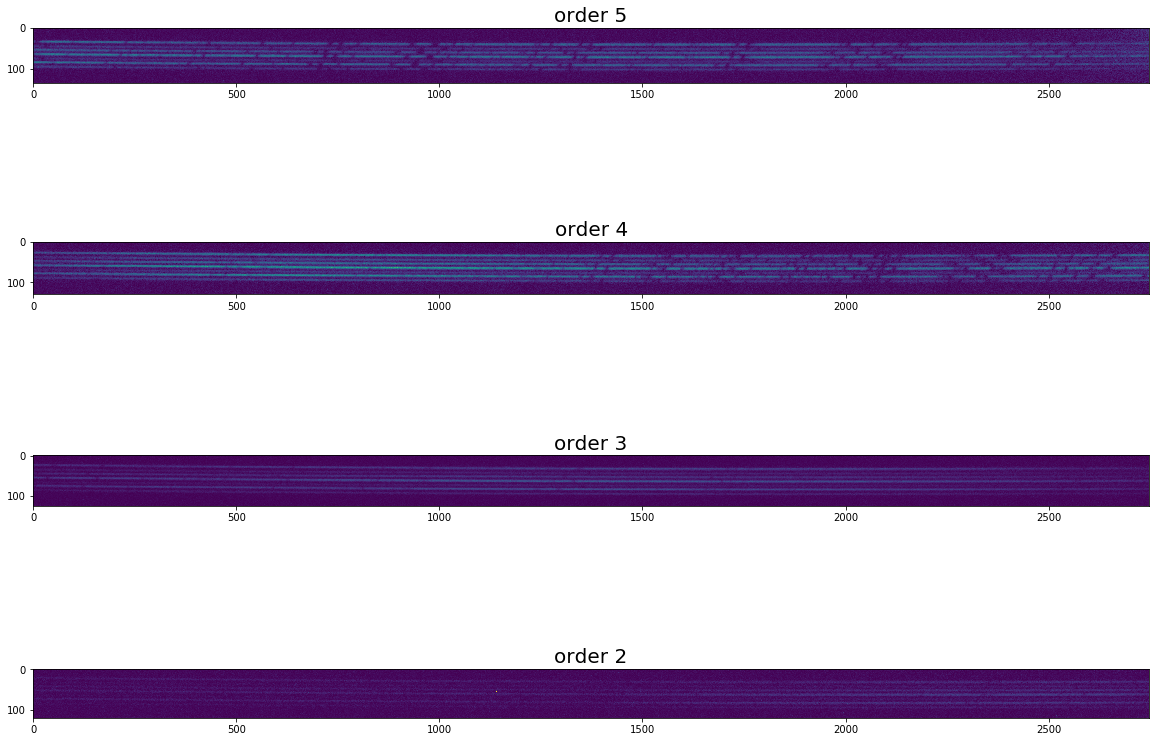

In [1334]:
orderflat5=ccdproc.trim_image(procflat[orders[6]:orders[5],:])
orderflat4=ccdproc.trim_image(procflat[orders[5]:orders[4],:])
orderflat3=ccdproc.trim_image(procflat[orders[4]:orders[3],:])
orderflat2=ccdproc.trim_image(procflat[orders[3]:orders[2],:])

ordercal5=ccdproc.trim_image(proccal[orders[6]:orders[5],:])
ordercal4=ccdproc.trim_image(proccal[orders[5]:orders[4],:])
ordercal3=ccdproc.trim_image(proccal[orders[4]:orders[3],:])
ordercal2=ccdproc.trim_image(proccal[orders[3]:orders[2],:])

ordersci5=ccdproc.trim_image(procsci[orders[6]:orders[5],:])
ordersci4=ccdproc.trim_image(procsci[orders[5]:orders[4],:])
ordersci3=ccdproc.trim_image(procsci[orders[4]:orders[3],:])
ordersci2=ccdproc.trim_image(procsci[orders[3]:orders[2],:])

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax = plt.subplot(4,1,1)
plt.title("order 5",fontsize=20)
ax.imshow(ordersci5,origin='upper',cmap='viridis')
ax = plt.subplot(4,1,2)
plt.title("order 4",fontsize=20)
ax.imshow(ordersci4,origin='upper',cmap='viridis')
ax = plt.subplot(4,1,3)
plt.title("order 3",fontsize=20)
ax.imshow(ordersci3,origin='upper',cmap='viridis')
ax = plt.subplot(4,1,4)
plt.title("order 2",fontsize=20)
ax.imshow(ordersci2,origin='upper',cmap='viridis')

## Process Order 5

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1335]:
# manually determine bound for central core start and end pixel row
cc0 = 60
cc1 = 72
curorder=5

Text(0.5,1,'Plot of pixel column 500 1500 2500 (cross dispersion direction) of Order 5')

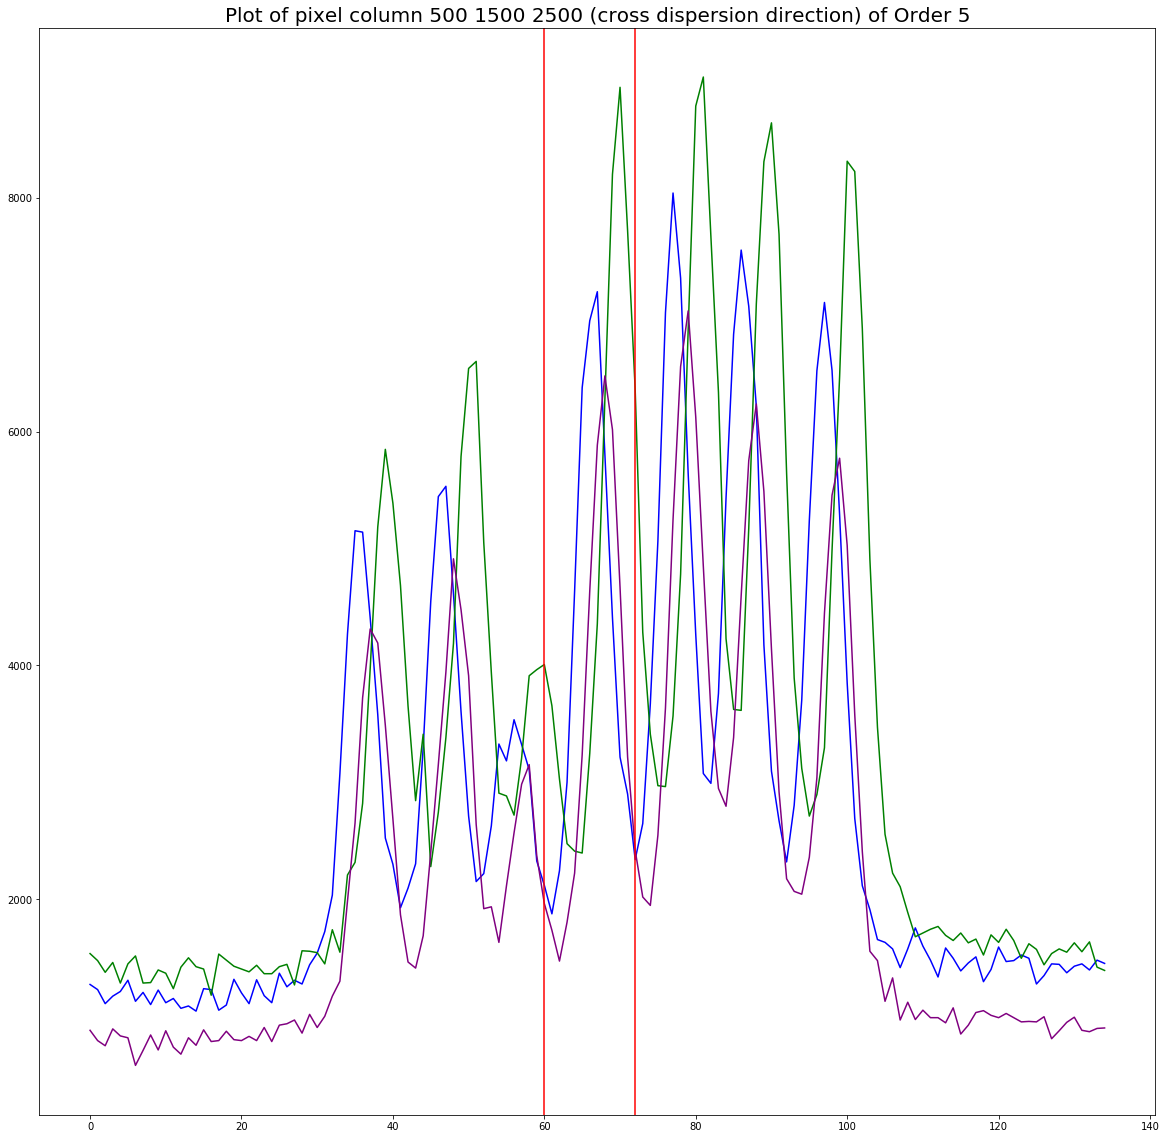

In [1336]:
whatcol1=500
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat5.data[:,whatcol1],color='blue')
plt.plot(orderflat5.data[:,whatcol2],color='green')
plt.plot(orderflat5.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

Plot outall the co9lumns superimposed to see if all the peaks of the central core will fit in the bound box

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1337]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
for i in range(detector_w):
    y, _ = find_peaks(orderflat5.data[cc0:cc1,i], height=2500)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat5.data[y[which_mcf]+cc0,i])
    
column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)


Text(0.5,1,'Order 5 center core pixel locations')

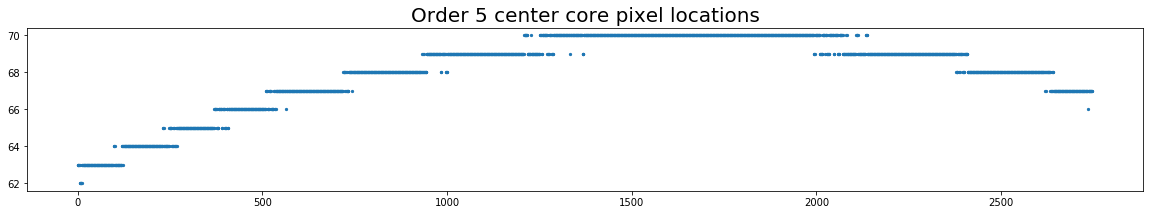

In [1338]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 5

### Plot the Central core, but instead of a rectangle window, take a window that is the center core +/- 10 pixels

In [1339]:
orderflat5array=orderflat5.data
ordercal5array=ordercal5.data
ordersci5array=ordersci5.data


crop_orderflat5array= []
crop_ordercal5array= []
crop_ordersci5array= []

#adjust the window around the core being extracted

#corewindow0 = 5
#corewindow1 = 7

corewindow0 = 10
corewindow1 = 10


i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat5array.append(orderflat5array[index_start:index_end,i])
    crop_ordercal5array.append(ordercal5array[index_start:index_end,i])
    crop_ordersci5array.append(ordersci5array[index_start:index_end,i])

crop_orderflat5array=np.array(crop_orderflat5array)
crop_ordercal5array=np.array(crop_ordercal5array)
crop_ordersci5array=np.array(crop_ordersci5array)

Text(0.5,1,'detector crop')

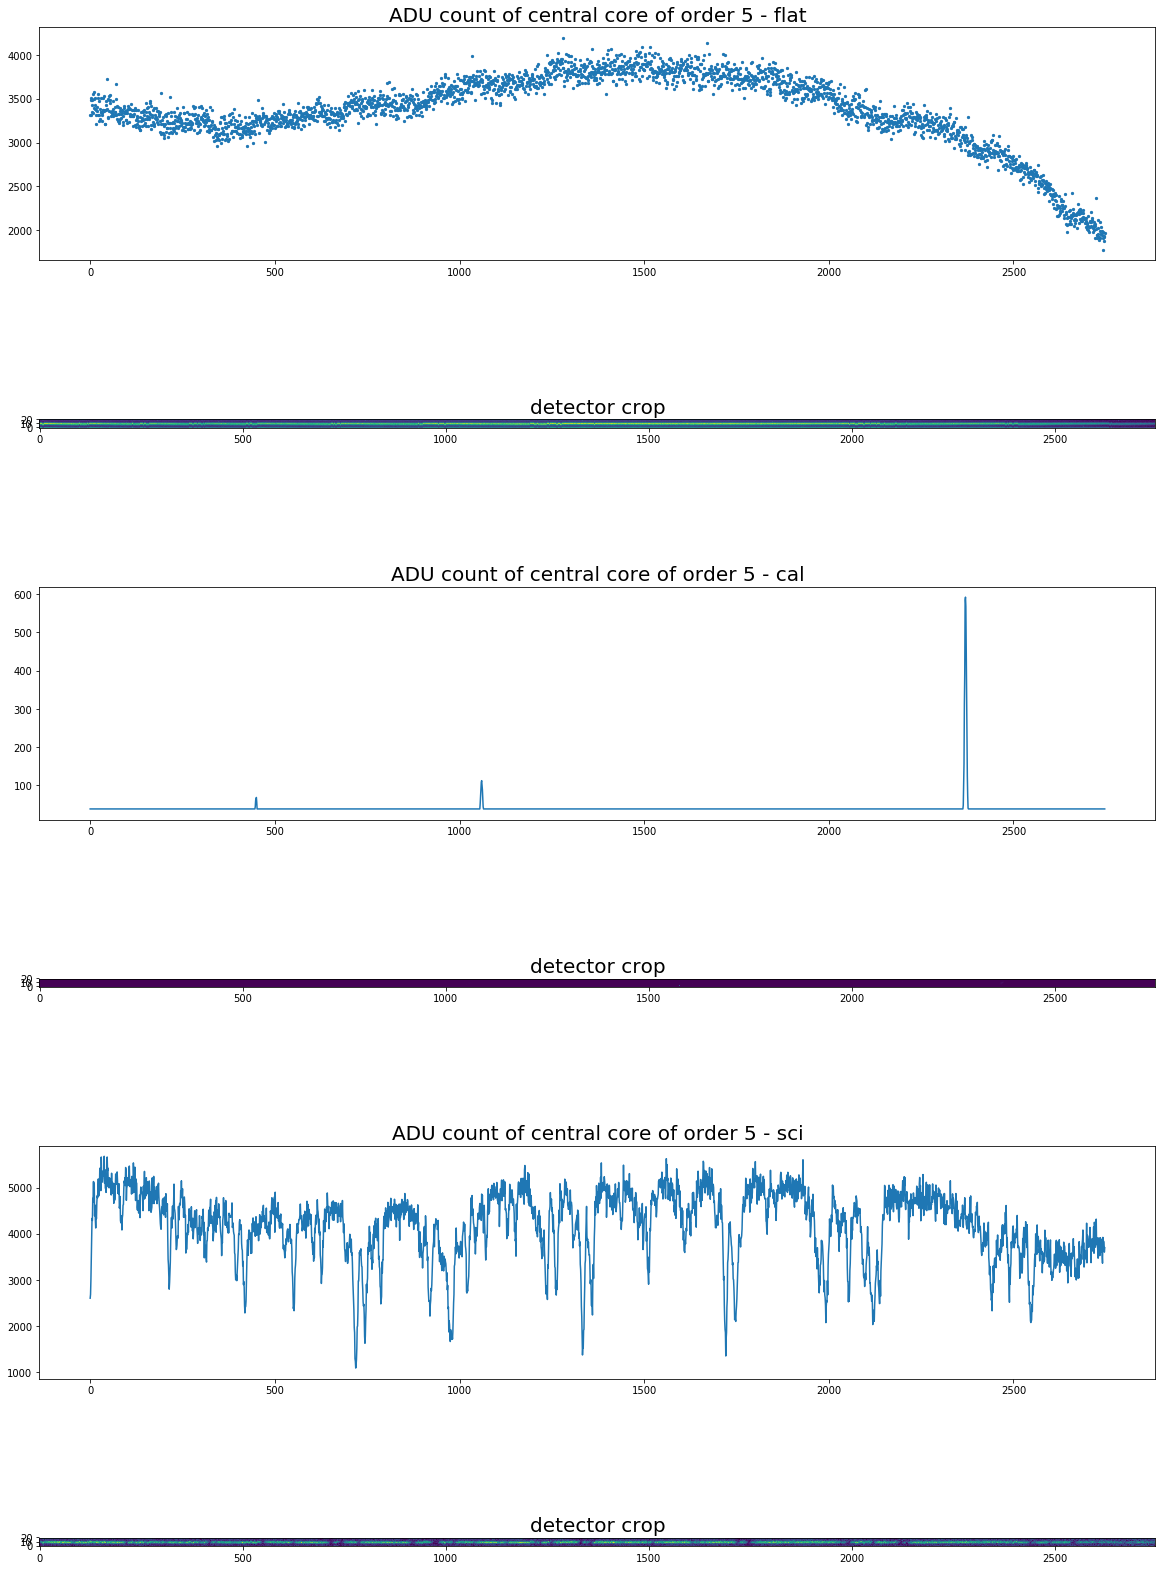

In [1340]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(6,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat5array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(6,1,2)
ax.imshow(np.rot90(crop_orderflat5array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal5array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal5array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(6,1,4)
ax.imshow(np.rot90(crop_ordercal5array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,5)
#plt.scatter(np.arange(detector_w),np.sum(crop_ordersci5array,axis=1),s=3)
plt.plot(np.sum(crop_ordersci5array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(6,1,6)
ax.imshow(np.rot90(crop_ordersci5array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

## Process Order 4

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1341]:
# manually determine bound for central core start and end pixel row
cc0 = 56
cc1 = 67
curorder=4

Text(0.5,1,'Plot of pixel column 500 1500 2500 (cross dispersion direction) of Order 4')

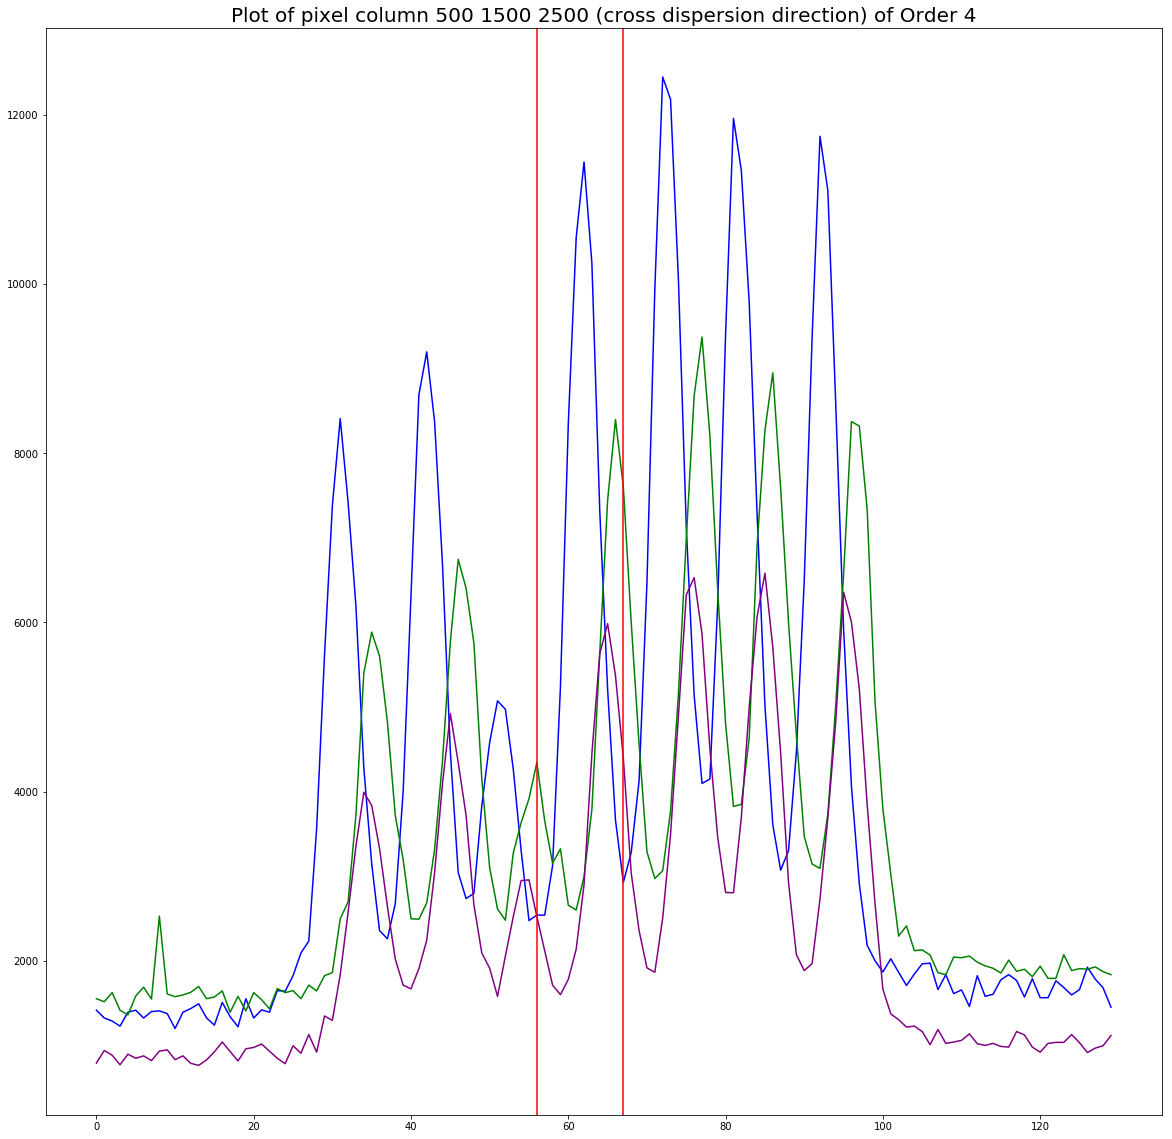

In [1342]:
whatcol1=500
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat4.data[:,whatcol1],color='blue')
plt.plot(orderflat4.data[:,whatcol2],color='green')
plt.plot(orderflat4.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

Plot out all the columns superimposed to see if all the peaks of the central core will fit in the bound box

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1343]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat4.data[cc0:cc1,i], height=2000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat4.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat4.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=9)
column_peaks_intensity = np.array(column_peaks_intensity)

Text(0.5,1,'Order 4 center core pixel locations')

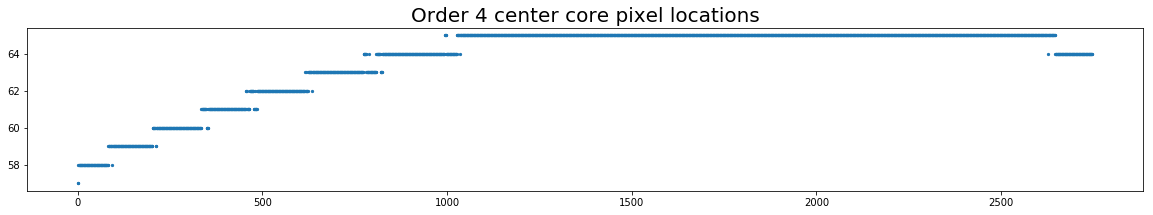

In [1344]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 4

### Plot the Central core, take a window that is about +/- 10 pixels around the center core

In [1346]:
orderflat4array=orderflat4.data
ordercal4array=ordercal4.data
ordersci4array=ordersci4.data


crop_orderflat4array= []
crop_ordercal4array= []
crop_ordersci4array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat4array.append(orderflat4array[index_start:index_end,i])
    crop_ordercal4array.append(ordercal4array[index_start:index_end,i])
    crop_ordersci4array.append(ordersci4array[index_start:index_end,i])

crop_orderflat4array=np.array(crop_orderflat4array)
crop_ordercal4array=np.array(crop_ordercal4array)
crop_ordersci4array=np.array(crop_ordersci4array)

Text(0.5,1,'detector crop')

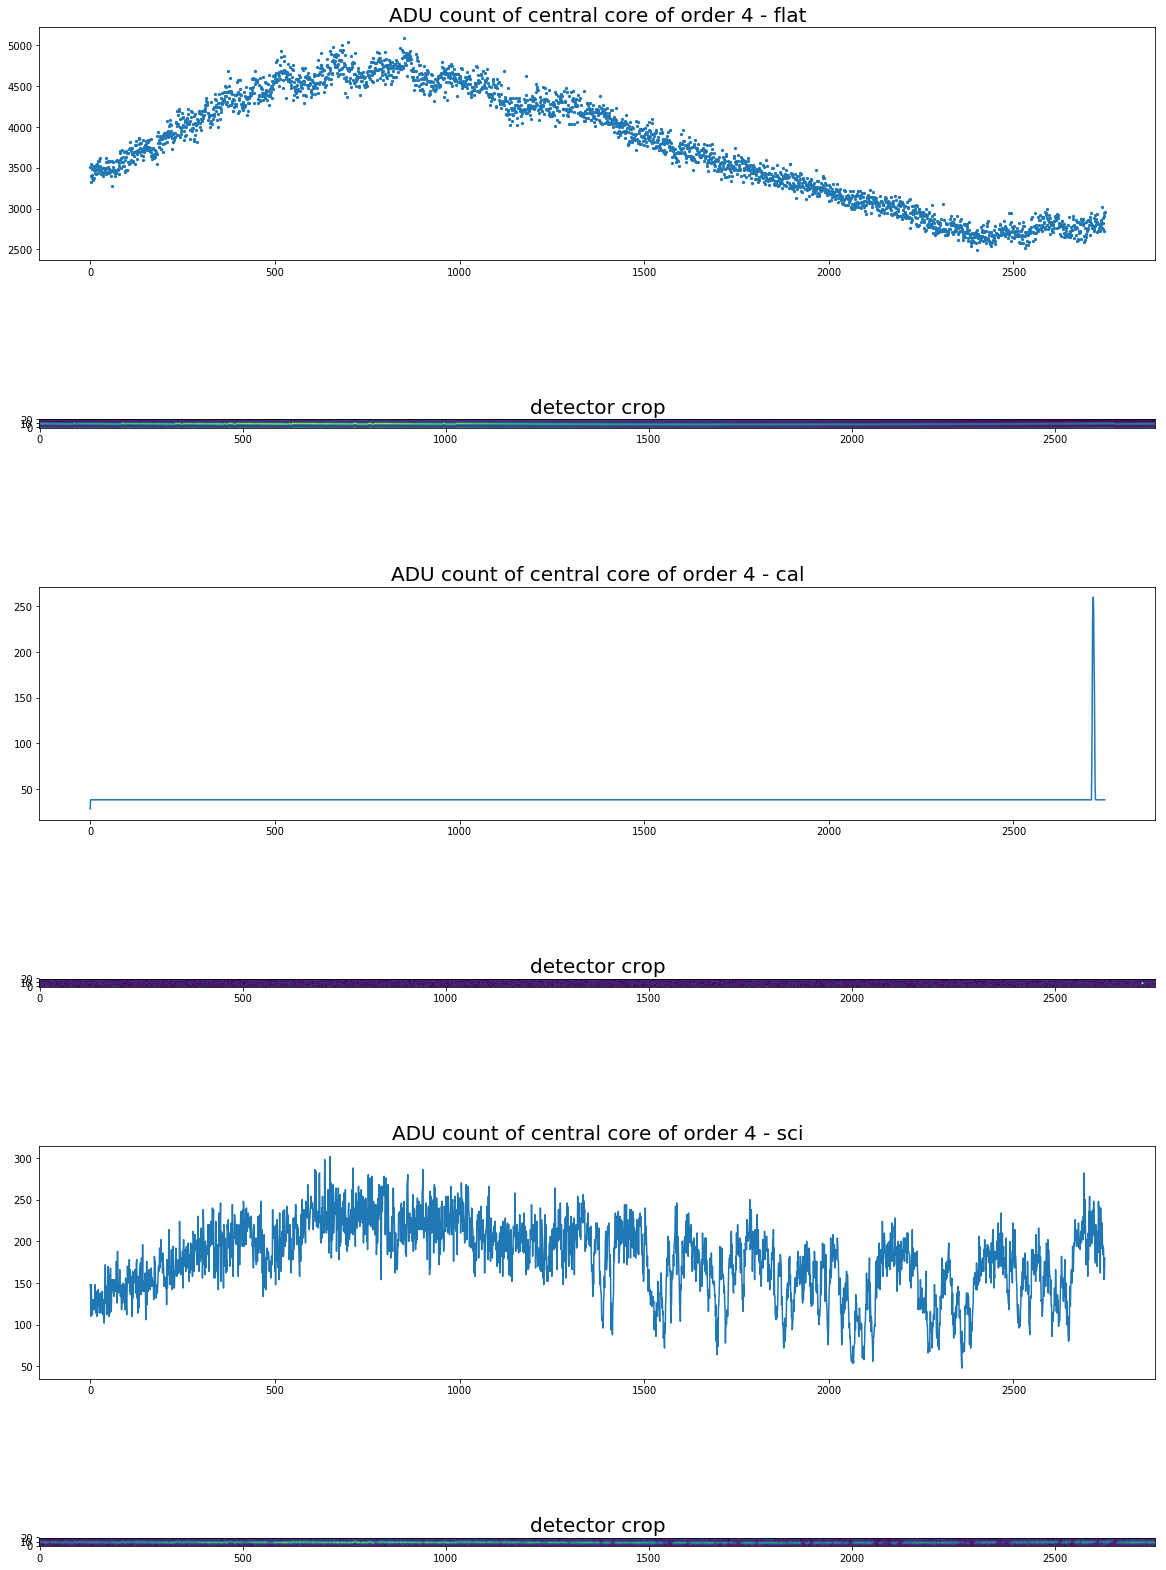

In [1347]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(6,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat4array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(6,1,2)
ax.imshow(np.rot90(crop_orderflat4array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal4array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal4array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(6,1,4)
ax.imshow(np.rot90(crop_ordercal4array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci4array,axis=1),s=5)
plt.plot(np.median(crop_ordersci4array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(6,1,6)
ax.imshow(np.rot90(crop_ordersci4array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

Not a big difference in the results

## Process Order 3

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1348]:
# manually determine bound for central core start and end pixel row
cc0 = 53
cc1 = 64
curorder=3

Text(0.5,1,'Plot of pixel column 0 1500 2500 (cross dispersion direction) of 3')

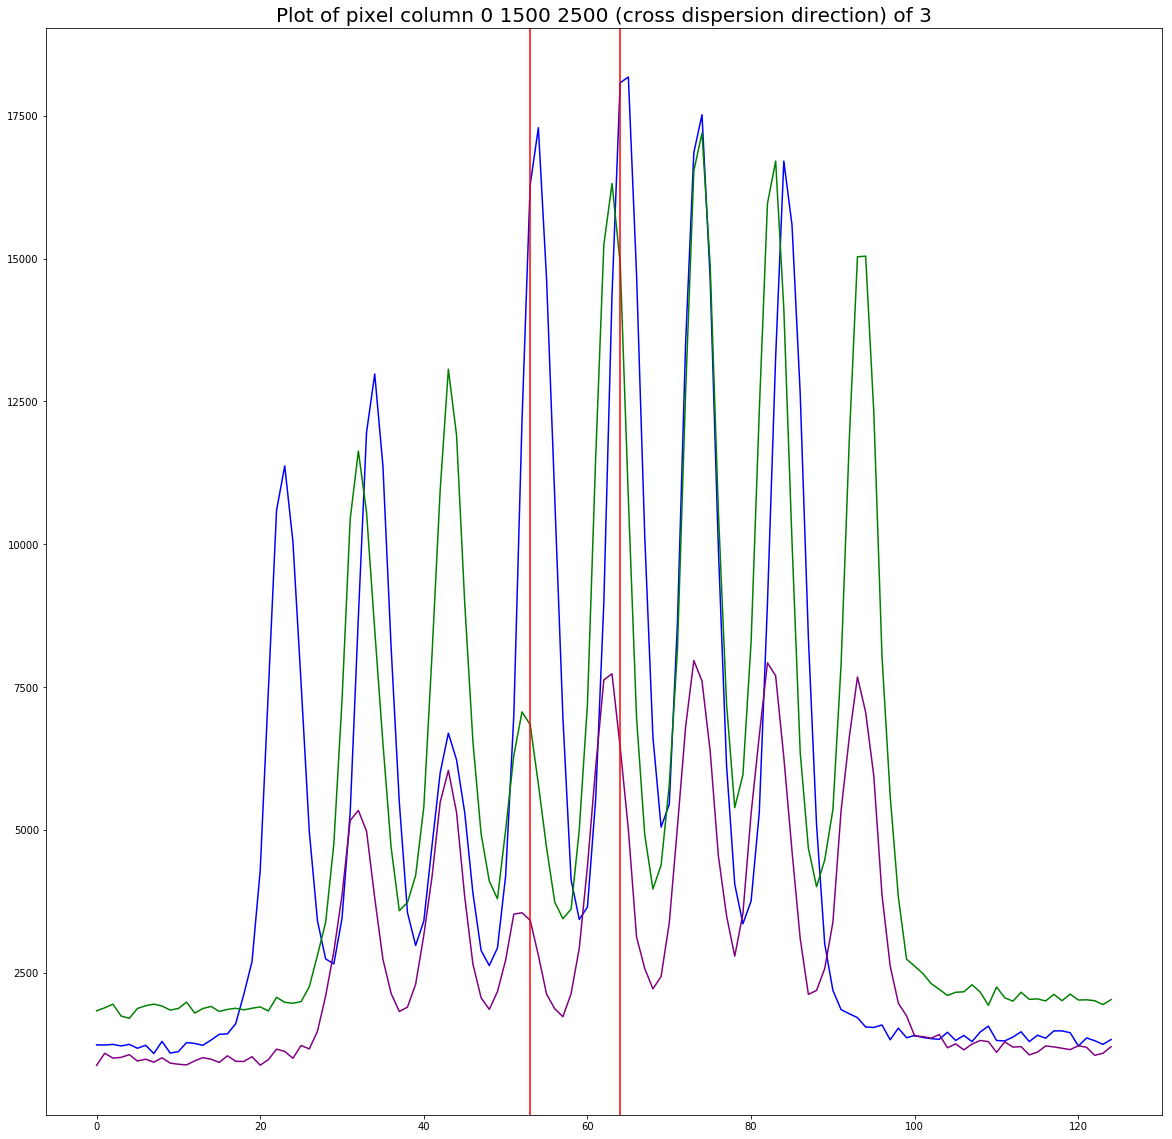

In [1349]:
whatcol1=0
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat3.data[:,whatcol1],color='blue')
plt.plot(orderflat3.data[:,whatcol2],color='green')
plt.plot(orderflat3.data[:,whatcol3],color='purple')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of " + str(curorder),fontsize=20)

Plot out all the columns superimposed to see if all the peaks of the central core will fit in the bound box

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1350]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat3.data[cc0:cc1,i],height=7000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat3.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat3.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=15)
column_peaks_intensity = np.array(column_peaks_intensity)

Text(0.5,1,'Order  3 center core pixel locations')

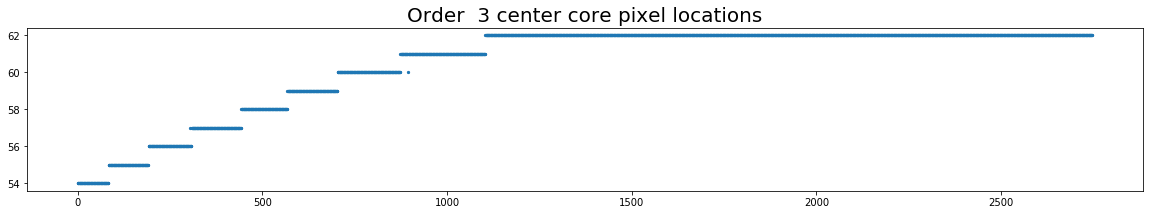

In [1351]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order  " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 3

### Plot the Central core, take a window that is +/- 10 pixels about the center core

In [1352]:
orderflat3array=orderflat3.data
ordercal3array=ordercal3.data
ordersci3array=ordersci3.data


crop_orderflat3array= []
crop_ordercal3array= []
crop_ordersci3array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat3array.append(orderflat3array[index_start:index_end,i])
    crop_ordercal3array.append(ordercal3array[index_start:index_end,i])
    crop_ordersci3array.append(ordersci3array[index_start:index_end,i])

crop_orderflat3array=np.array(crop_orderflat3array)
crop_ordercal3array=np.array(crop_ordercal3array)
crop_ordersci3array=np.array(crop_ordersci3array)

Text(0.5,1,'detector crop')

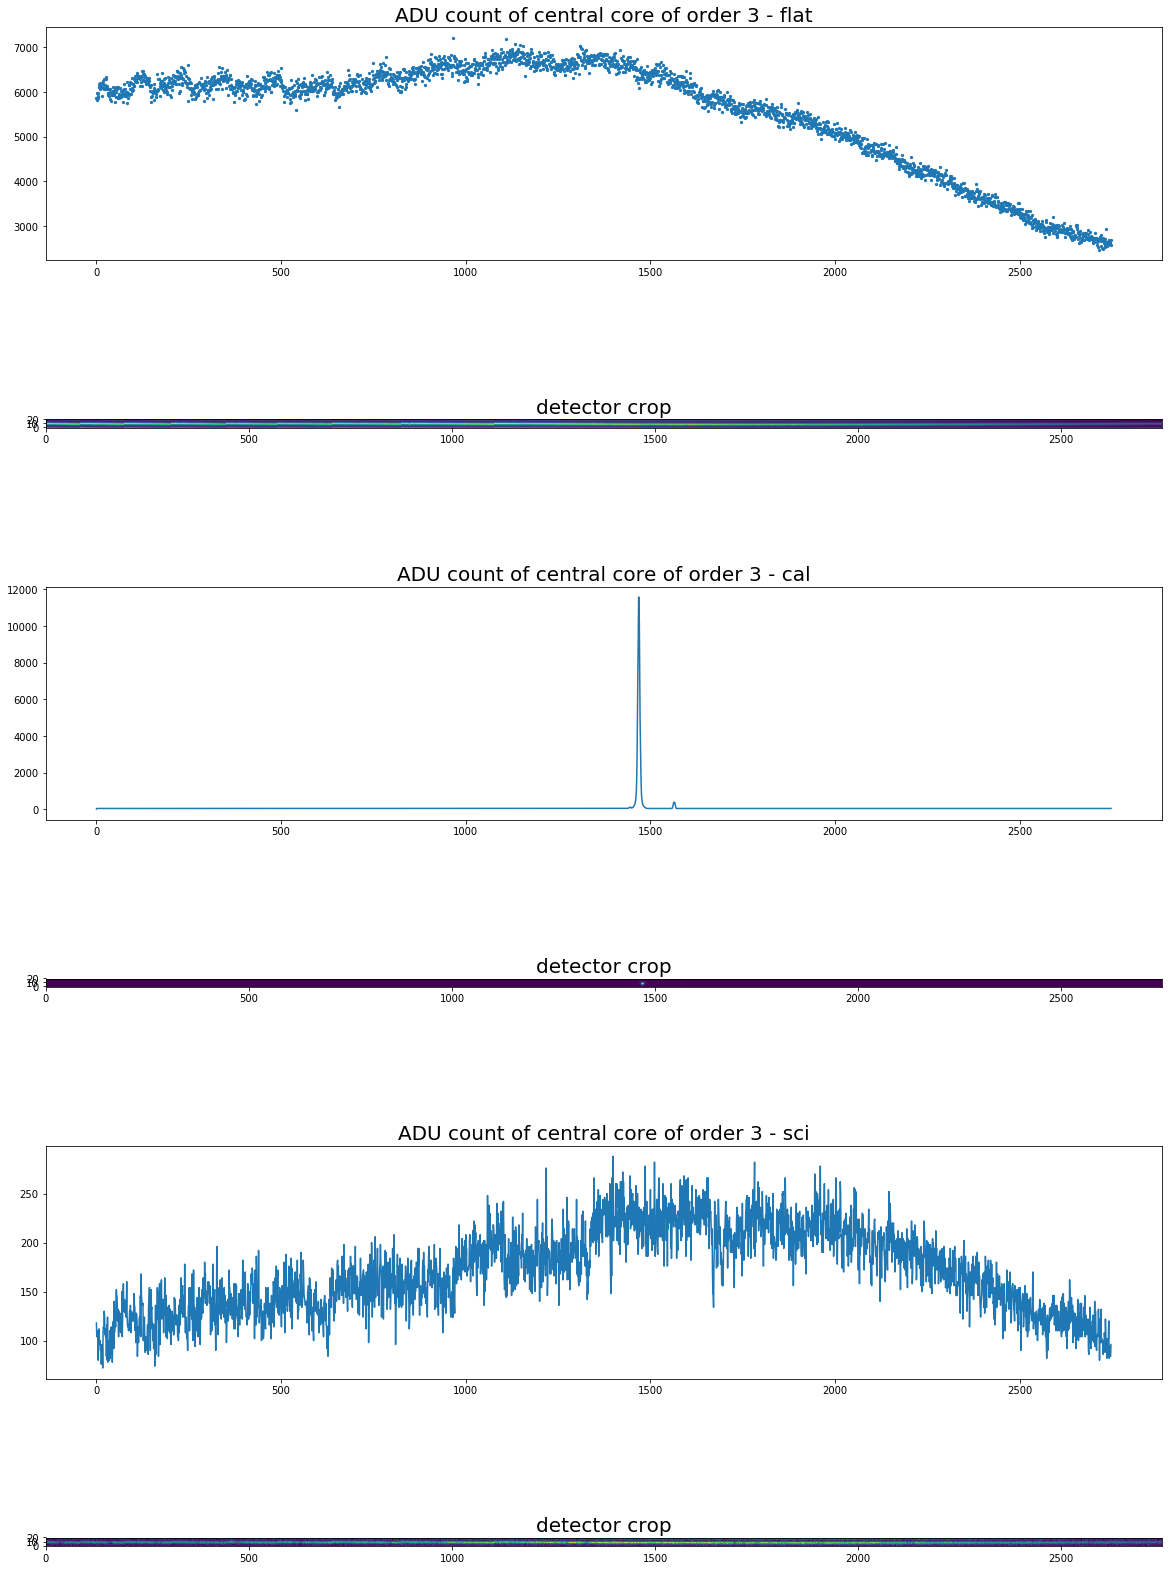

In [1353]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(6,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat3array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(6,1,2)
ax.imshow(np.rot90(crop_orderflat3array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal3array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal3array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(6,1,4)
ax.imshow(np.rot90(crop_ordercal3array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci3array,axis=1),s=5)
plt.plot(np.median(crop_ordersci3array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(6,1,6)
ax.imshow(np.rot90(crop_ordersci3array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

## Process Order 2

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [1354]:
# manually determine bound for central core start and end pixel row
cc0 = 50
cc1 = 64
curorder=2

Text(0.5,1,'Plot of pixel column 0 1500 2500 (cross dispersion direction) of Order 2')

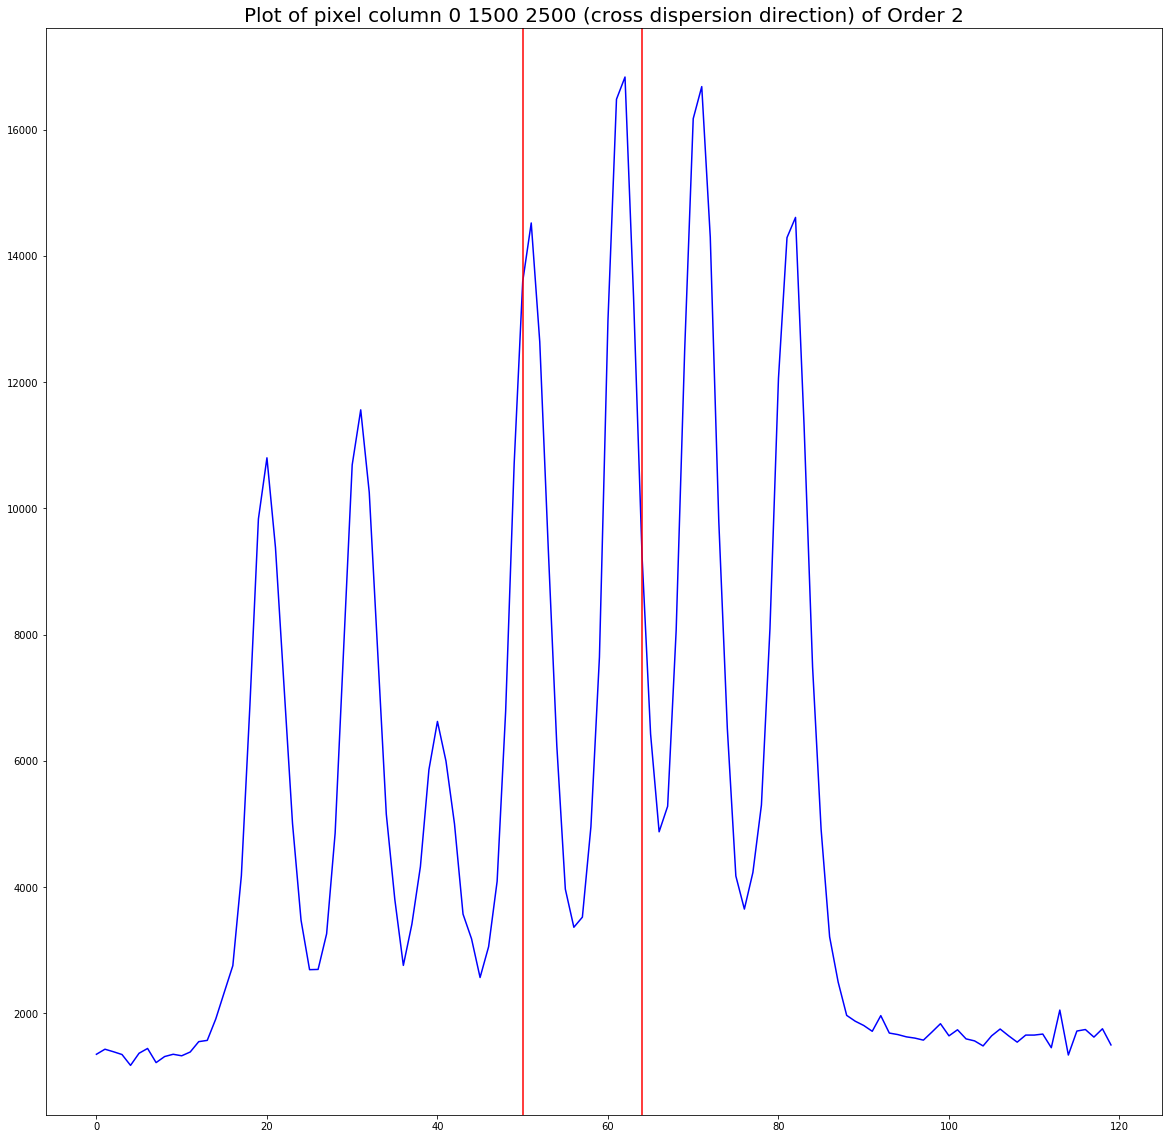

In [1355]:
whatcol1=0
whatcol2=1500
whatcol3=2500

plt.figure(figsize=(20, 20))
plt.plot(orderflat2.data[:,whatcol1],color='blue')
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column " + str(whatcol1) + " " + str(whatcol2) + " " + str(whatcol3) + " (cross dispersion direction) of Order " + str(curorder),fontsize=20)

Plot out all the columns superimposed to see if all the peaks of the central core will fit in the bound box

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [1356]:
column_peaks = []
column_peaks_intensity = []
which_mcf = 0

for i in range(detector_w):
    y, _ = find_peaks(orderflat2.data[cc0:cc1,i],height=7000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat2.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat2.data[y[which_mcf]+cc0,i])

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=15)
column_peaks_intensity = np.array(column_peaks_intensity)

Text(0.5,1,'Order  2 center core pixel locations')

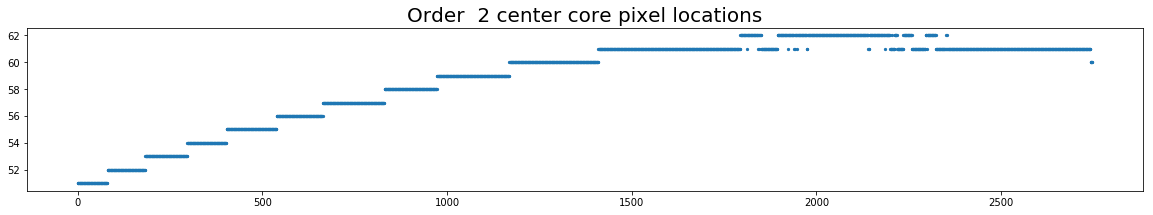

In [1357]:
plt.figure(figsize=(20, 3))
plt.scatter(np.arange(detector_w),column_peaks,s=5)
plt.title("Order  " + str(curorder) + " center core pixel locations",fontsize=20)

### crop out just the center core of order 2

### Plot the Central core, take a window that is +/- 10 pixels about the center core

In [1358]:
orderflat2array=orderflat2.data
ordercal2array=ordercal2.data
ordersci2array=ordersci2.data


crop_orderflat2array= []
crop_ordercal2array= []
crop_ordersci2array= []

#adjust the window around the core being extracted

corewindow0 = 10
corewindow1 = 10

i=0
for i in range(column_peaks.shape[0]):
    index_start = int(column_peaks[i]-corewindow0)
    index_end = int(column_peaks[i]+corewindow1)
    crop_orderflat2array.append(orderflat2array[index_start:index_end,i])
    crop_ordercal2array.append(ordercal2array[index_start:index_end,i])
    crop_ordersci2array.append(ordersci2array[index_start:index_end,i])

crop_orderflat2array=np.array(crop_orderflat2array)
crop_ordercal2array=np.array(crop_ordercal2array)
crop_ordersci2array=np.array(crop_ordersci2array)

Text(0.5,1,'detector crop')

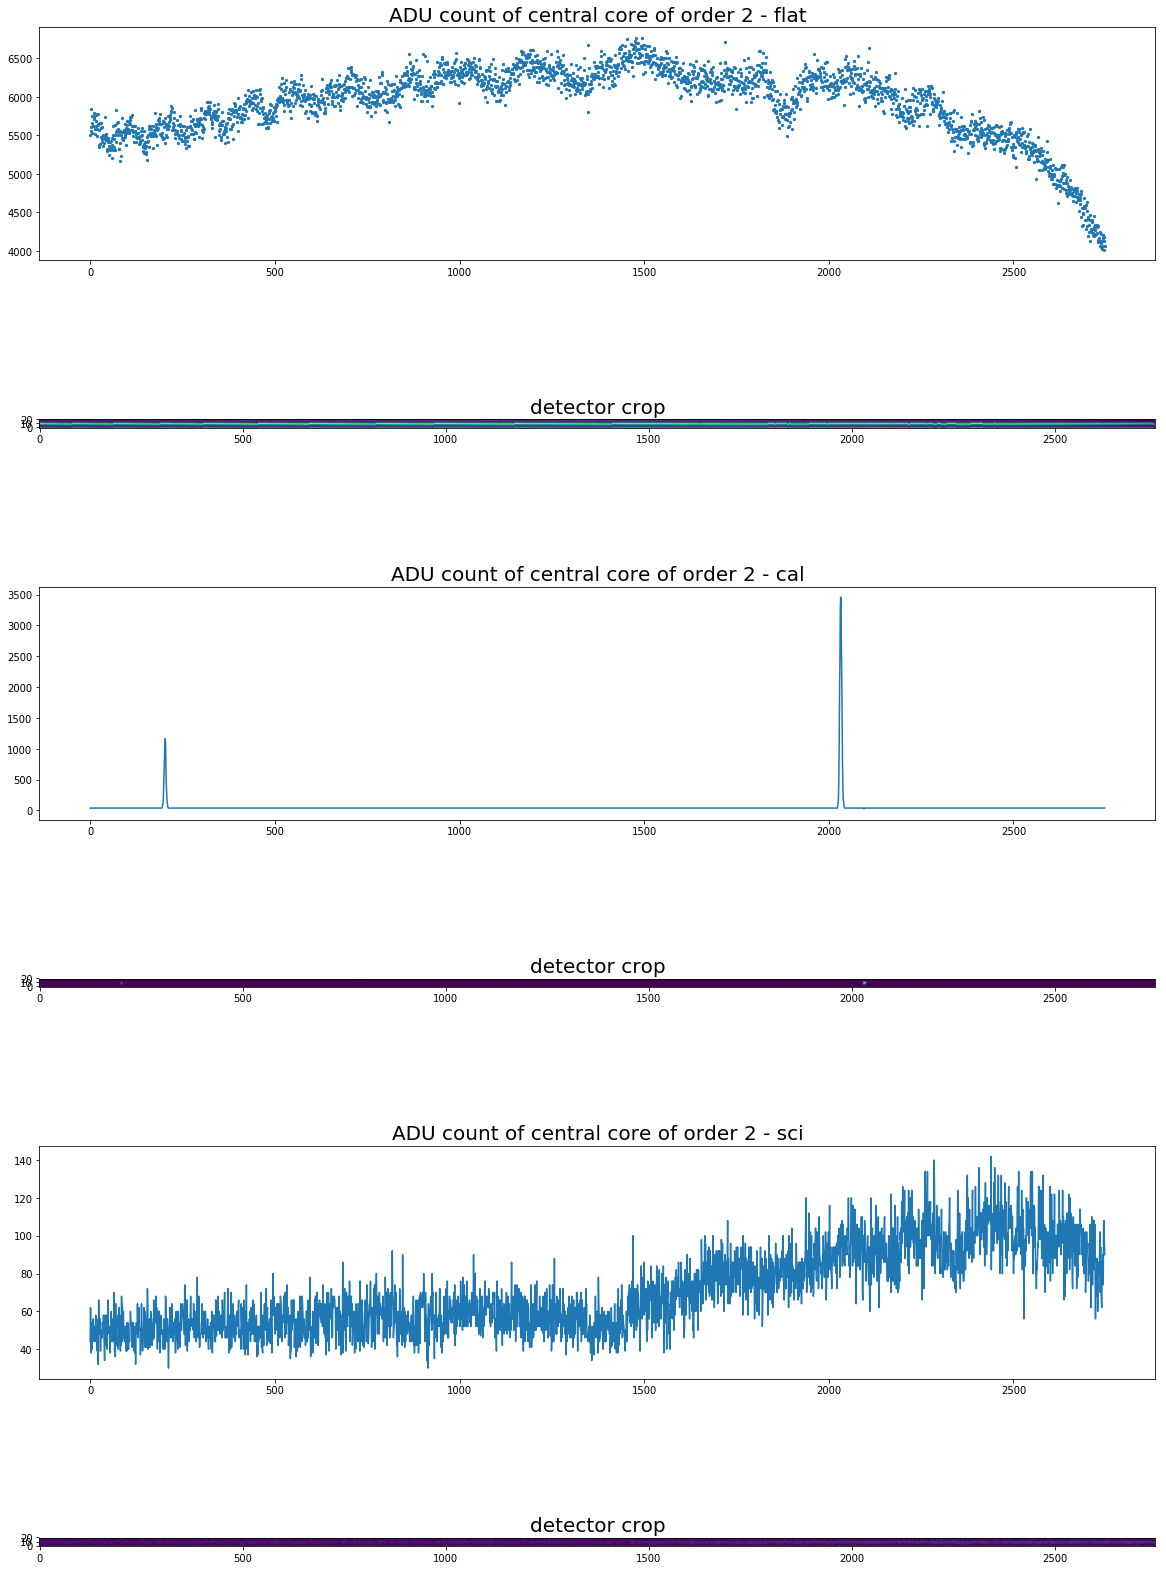

In [1359]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 30)

ax = plt.subplot(6,1,1)
plt.scatter(np.arange(detector_w),np.median(crop_orderflat2array,axis=1),s=5)
plt.title("ADU count of central core of order " + str(curorder) + " - flat",fontsize=20)

ax = plt.subplot(6,1,2)
ax.imshow(np.rot90(crop_orderflat2array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,3)
#plt.scatter(np.arange(detector_w),np.max(medfilt(crop_ordercal2array,5),axis=1),s=5)
plt.plot(np.max(medfilt(crop_ordercal2array,5),axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - cal",fontsize=20)

ax = plt.subplot(6,1,4)
ax.imshow(np.rot90(crop_ordercal2array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

ax = plt.subplot(6,1,5)
#plt.scatter(np.arange(detector_w),np.median(crop_ordersci2array,axis=1),s=5)
plt.plot(np.median(crop_ordersci2array,axis=1))
plt.title("ADU count of central core of order " + str(curorder) + " - sci",fontsize=20)

ax = plt.subplot(6,1,6)
ax.imshow(np.rot90(crop_ordersci2array),origin='lower',cmap='viridis')
plt.title("detector crop",fontsize=20)

### XE spectral atlast for 900 - 1000 nm here

https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Xe&limits_type=0&low_w=900&upp_w=1000&unit=1&de=0&lte_out=2&format=3&line_out=1&remove_js=on&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on&submit=Retrieve+Data

In [1360]:
XE_lambda = [904.5448,916.2653,924.5188,930.6622,979.9699,992.3190]
XE_intensity = [400,500,3,40,2000,3000]

Text(0.5,1,'XE lines from 900 nm to 1000 nm (rel. intensity vs wavelength in nm)')

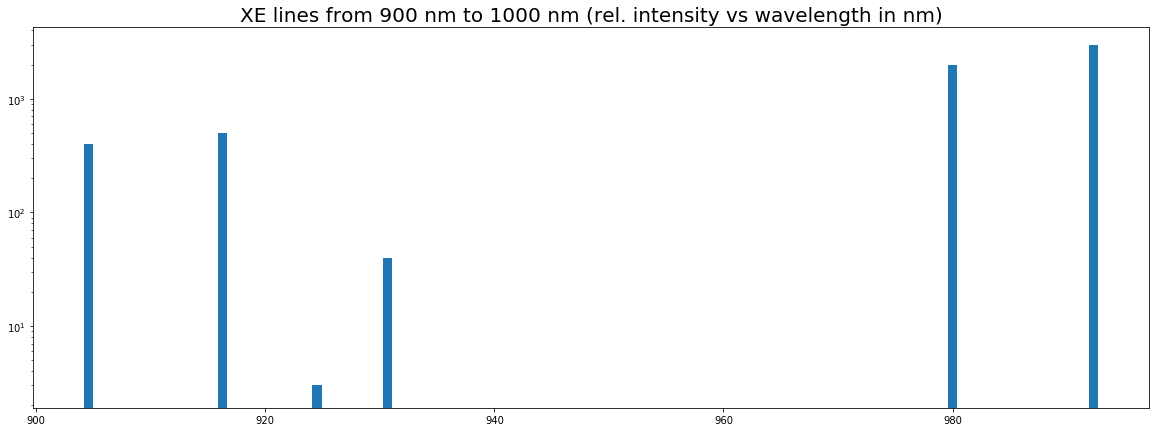

In [1361]:
plt.figure(figsize=(20, 7))
plt.yscale('log')
plt.bar(XE_lambda,XE_intensity)
plt.title("XE lines from 900 nm to 1000 nm (rel. intensity vs wavelength in nm)",fontsize=20)

Text(0.5,1,'ADU counts of xe spectrum in orders 2,3,4,5')

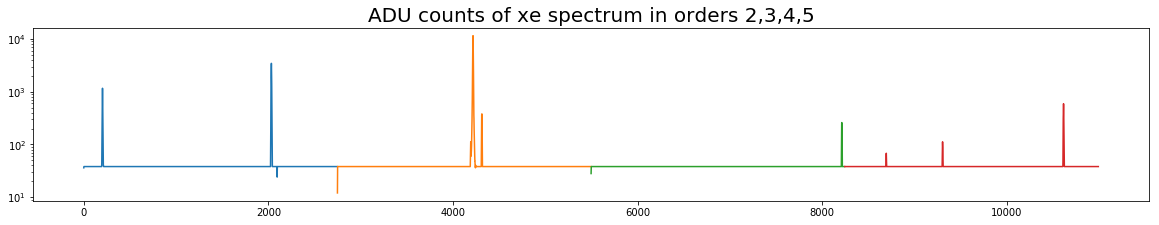

In [1362]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.yscale('log')
#plt.scatter(np.arange(detector_w),np.median(ordercal2cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w,detector_w*2),np.median(ordercal3cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w*2,detector_w*3),np.median(ordercal4cc,axis=0),s=5)
#plt.scatter(np.arange(detector_w*3,detector_w*4),np.median(ordercal5cc,axis=0),s=5)

plt.plot(np.arange(detector_w),np.max(medfilt(crop_ordercal2array,5),axis=1))
plt.plot(np.arange(detector_w,detector_w*2),np.max(medfilt(crop_ordercal3array,5),axis=1))
plt.plot(np.arange(detector_w*2,detector_w*3),np.max(medfilt(crop_ordercal4array,5),axis=1))
plt.plot(np.arange(detector_w*3,detector_w*4),np.max(medfilt(crop_ordercal5array,5),axis=1))

plt.title("ADU counts of xe spectrum in orders 2,3,4,5",fontsize=20)